In [19]:

import open3d as o3d
import os
import glob
from data_importer import PointCloudManager, DataExtractor

base_folder = "postPCD"  # dir to PCD folders
manager = PointCloudManager(base_folder)
pcd_mic, pcd, filtered_pcd = manager.run()

extractor = DataExtractor('HP-side-vvs-0.6m.mat')
recording = extractor.load_data()

Available subfolders:
0: AP-align_20231216_122743
1: AP-modify_20231208_161053
2: AP-noy-187_20231208_162247
3: AP-noy_20231208_161813
4: AP-side-0.7m-highRes_20231208_154153
5: HP-hr-0.4m-rc_20231211_150219
6: HP-rc-side_20231211_151710
7: HP-side~0.4m-hr_20231211_143359
8: HP-vvs-0.7_20231216_132553
9: vvs-20kHz-12.8k-rightEar-realigned_20231120_163043


In [4]:
from SoundFieldAnalysis import SoundFieldAnalysis

freq = 4000
# initialize the variables
BF_analysis = SoundFieldAnalysis(pcd_mic,recording,filtered_pcd, freq=freq)
result_J = BF_analysis.calculate()

In [23]:
import numpy as np
from SoundFieldAnalysis import SoundFieldAnalysis

S = BF_analysis.S
Pxy = BF_analysis.Pxy
f = BF_analysis.f
index = np.argmin(np.abs(f - freq))
print(S.shape)
eigenVal, eigenVec = np.linalg.eig(S)

NameError: name 'BF_analysis' is not defined

c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


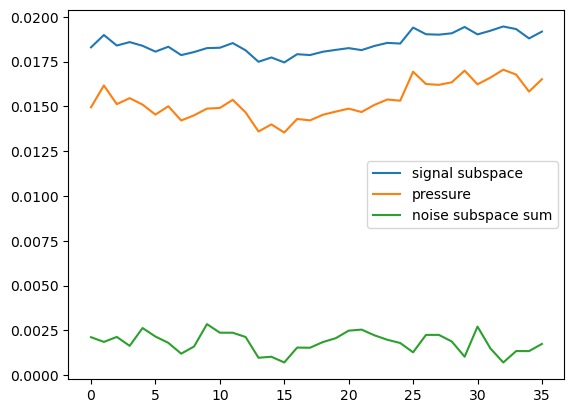

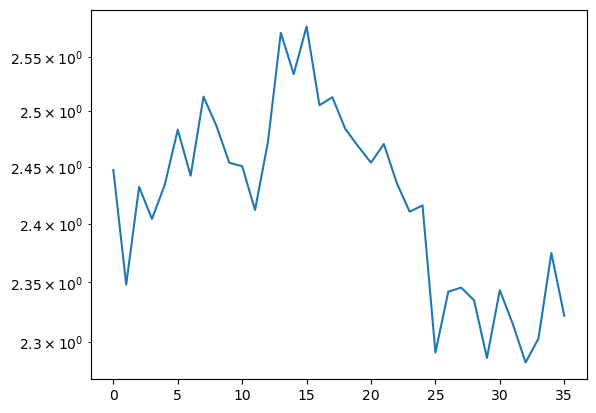

In [87]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.sqrt(eigenVec[:,0]*eigenVal[0])/2, label = "signal subspace")
plt.plot(np.sqrt(Pxy[:,index]), label = "pressure")
plt.plot(1/35*np.sum(np.sqrt(eigenVec[:,1:]*eigenVal[1:]), axis = -1), label = "noise subspace sum")
plt.legend()
plt.show()

plt.Figure()
plt.semilogy(np.sqrt(eigenVec[:,0]*eigenVal[0]) / np.sqrt(Pxy[:,index]))
plt.show()

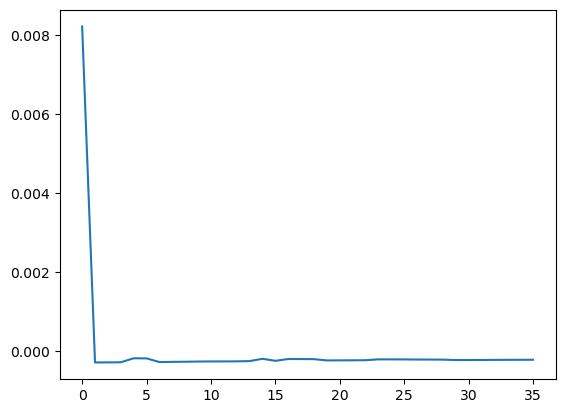

In [88]:
plt.plot(eigenVal[0:36])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (36, 35) and arg 2 with shape (36, 36).

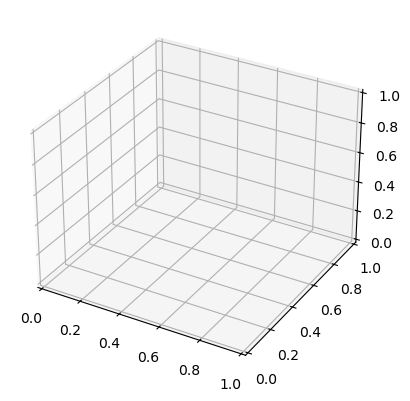

In [89]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0, 34, 35)
y = np.linspace(0, 35, 36)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, S, cmap='viridis')

plt.figure()
plt.plot(eigenVal)

In [90]:
import ipywidgets as widgets

def plot_eigenVec(index):
    plt.figure(figsize=(10, 6))
    plt.plot(E_n[:, index])
    plt.title(f'Plot for eigenVec[:, {index}]')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

# 创建滑块
slider = widgets.IntSlider(min=0, max=eigenVec.shape[1]-1, step=1, value=10, description='Index:')

# 使用interact连接滑块和绘图函数
widgets.interact(plot_eigenVec, index=slider)

interactive(children=(IntSlider(value=10, description='Index:', max=35), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eigenVec(index)>

In [24]:
import scipy


mic_array = np.array(pcd_mic.points)
sound_field = recording
points = np.array(filtered_pcd.points)
idx = eigenVal.argsort()[::-1]   
eigenVal = eigenVal[idx]
eigenVec = eigenVec[:,idx]

plt.plot(eigenVal)

NameError: name 'eigenVal' is not defined

In [92]:

# main part of MUSIC
eigenVal, eigenVec = np.linalg.eig(S)
E_n = eigenVec[:,1:]*eigenVal[1:]
P = []

omega = 2*np.pi*f[index]
C = 343
k = omega/C

distance = scipy.spatial.distance.cdist(mic_array, points, metric="euclidean")
v = np.exp(-1j * k * distance) / distance

for i in range(len(distance[2,:])):
    a = v[:,i]
    Pi =  1/(np.abs(a.conj().T @ E_n @ E_n.conj().T @ a))**2
    P.append(Pi)



In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_point_cloud(plane='xy', density=1, center=(0, 0, 0), num_points=100):
    """
    Generate a point cloud matrix on a plane.

    :param plane: Plane of the point cloud ('xy', 'xz', or 'yz').
    :param density: Density of the points in the matrix.
    :param center: Center of the point cloud (x, y, z).
    :param num_points: Number of points in the cloud.
    :return: Array of points in the point cloud.
    """
    # Generate random offsets
    offsets = np.random.rand(num_points, 2) * density - (density / 2)

    # Initialize points array
    points = np.zeros((num_points, 3))

    # Assign points based on the selected plane
    if plane == 'xy':
        points[:, 0] = offsets[:, 0] + center[0]
        points[:, 1] = offsets[:, 1] + center[1]
        points[:, 2] = center[2]
    elif plane == 'xz':
        points[:, 0] = offsets[:, 0] + center[0]
        points[:, 1] = center[1]
        points[:, 2] = offsets[:, 1] + center[2]
    elif plane == 'yz':
        points[:, 0] = center[0]
        points[:, 1] = offsets[:, 0] + center[1]
        points[:, 2] = offsets[:, 1] + center[2]

    return points


In [37]:
vis = o3d.visualization.VisualizerWithEditing()
vis.create_window()
vis.add_geometry(filtered_pcd)
vis.run()  # 用户选择点
vis.destroy_window()

filtered_pcd = vis.get_cropped_geometry()

points = np.array(filtered_pcd.points)

In [33]:
# Calculate MUSIC at plane
from SoundFieldAnalysis import SoundFieldAnalysis

plane_point = generate_point_cloud(plane='xy', density=0.5, center=(0.2, 0.1, -0.3), num_points=9000)
tempcd = o3d.geometry.PointCloud()
tempcd.points = o3d.utility.Vector3dVector(plane_point)
sfa = SoundFieldAnalysis(pcd_mic, sound_field, tempcd, freq = 500)
result_J_plane = sfa.calculate()
P_plane = sfa.MUSIC()


In [34]:

sfa = SoundFieldAnalysis(pcd_mic, sound_field, filtered_pcd, freq = 500)
result_J = sfa.calculate()
P = sfa.MUSIC()

In [52]:
eps1 = 0.01* np.linalg.norm(np.sqrt(Pxy[:,index]))

eps2 = 0.01*np.linalg.norm(np.sqrt(eigenVec[:,0]))

x = np.zeros(len(v[2,:]))
b = eigenVec[:,0]
ans = np.linalg.norm(v.T@(v @ x - b))

In [38]:
import pyvista as pv

# P = np.array(P)
# plotc = BF_analysis.plotc
def gen_cloud(P, points, dynamic):
    plotc = 20* np.log10(np.array(P))
    plotc_max = np.max(plotc)
    plotc_min = plotc_max - dynamic

    plotc_clamped = np.clip(plotc, plotc_min, plotc_max)

    # Assuming self.points are your point coordinates and plotc is the scalar value for each point
    cloud = pv.PolyData(points)
    cloud["Sound Pressure(dB)"] = plotc_clamped  # Adding scalar values to the point cloud
    return cloud

cloud1 = gen_cloud(P,points,20)
cloud2 = gen_cloud(P_plane, plane_point,20)
cloud3 = gen_cloud(result_J_plane, plane_point,20)
cloud4 = gen_cloud(result_J, points,5)



In [40]:

# Create a Plotter object and add the point cloud
plotter = pv.Plotter()
plotter.add_mesh(cloud1, cmap='rainbow', scalars='Sound Pressure(dB)', render_points_as_spheres=True, point_size=4)
# plotter.add_mesh(cloud2, cmap='rainbow', scalars='Sound Pressure(dB)', render_points_as_spheres=True, point_size=4)

# Show the point cloud
plotter.show()

Task exception was never retrieved
future: <Task finished name='Task-2814' coro=<WslinkHandler.sendWrappedMessage() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py:423> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 477, in sendWrappedMessage
    await ws.send_bytes(attachments[key])
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 343, in send_bytes
    await self._writer.send(data, binary=True, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 721, in send
    await self._send_frame(message, WSMsgT

Task exception was never retrieved
future: <Task finished name='Task-2838' coro=<WebSocketWriter.ping() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py:705> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 709, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 696, in _write
    raise ConnectionResetError("Cannot write to closing transport

Widget(value="<iframe src='http://localhost:52096/index.html?ui=P_0x1d25ec91d50_7&reconnect=auto' style='width…

In [15]:
plotter = pv.Plotter()
plotter.add_mesh(cloud1, cmap='rainbow', scalars='Sound Pressure(dB)', render_points_as_spheres=True, point_size=4)
plotter.add_mesh(cloud2, cmap='rainbow', scalars='Sound Pressure(dB)', render_points_as_spheres=True, point_size=4)

# Show the point cloud
plotter.show()

Widget(value="<iframe src='http://localhost:52096/index.html?ui=P_0x1d2351a53c0_2&reconnect=auto' style='width…

Task exception was never retrieved
future: <Task finished name='Task-89' coro=<WslinkHandler.sendWrappedMessage() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py:423> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 477, in sendWrappedMessage
    await ws.send_bytes(attachments[key])
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 343, in send_bytes
    await self._writer.send(data, binary=True, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 721, in send
    await self._send_frame(message, WSMsgTyp

In [ ]:
plane_point = generate_point_cloud(plane='xy', density=10, center=(0.2, 0.1, -0.3), num_points=90000)
tempcd = o3d.geometry.PointCloud()
tempcd.points = o3d.utility.Vector3dVector(plane_point)
sfa = SoundFieldAnalysis(pcd_mic, sound_field, tempcd, freq = 4000)
result_J_plane = sfa.calculate()

sfa = SoundFieldAnalysis(pcd_mic, sound_field, filtered_pcd, freq = 500)
result_J = sfa.calculate()

cloud3 = gen_cloud(result_J_plane, plane_point,20)
cloud4 = gen_cloud(result_J, points,5)

plotter = pv.Plotter()
plotter.add_mesh(cloud3, cmap='rainbow', scalars='Sound Pressure(dB)', render_points_as_spheres=True, point_size=4)
plotter.add_mesh(cloud4, cmap='rainbow', scalars='Sound Pressure(dB)', render_points_as_spheres=True, point_size=4)

# Show the point cloud
plotter.show()

c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\pyvista\plotting\mapper.py:637: ComplexWarning: Casting complex values to real discards the imaginary part
  scalars = scalars.astype(float)


Widget(value="<iframe src='http://localhost:52096/index.html?ui=P_0x1d263b4c460_3&reconnect=auto' style='width…

Task exception was never retrieved
future: <Task finished name='Task-317' coro=<WslinkHandler.sendWrappedMessage() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py:423> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, comp

c:\Users\lieng\.conda\envs\my_new_env\envs\environment\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


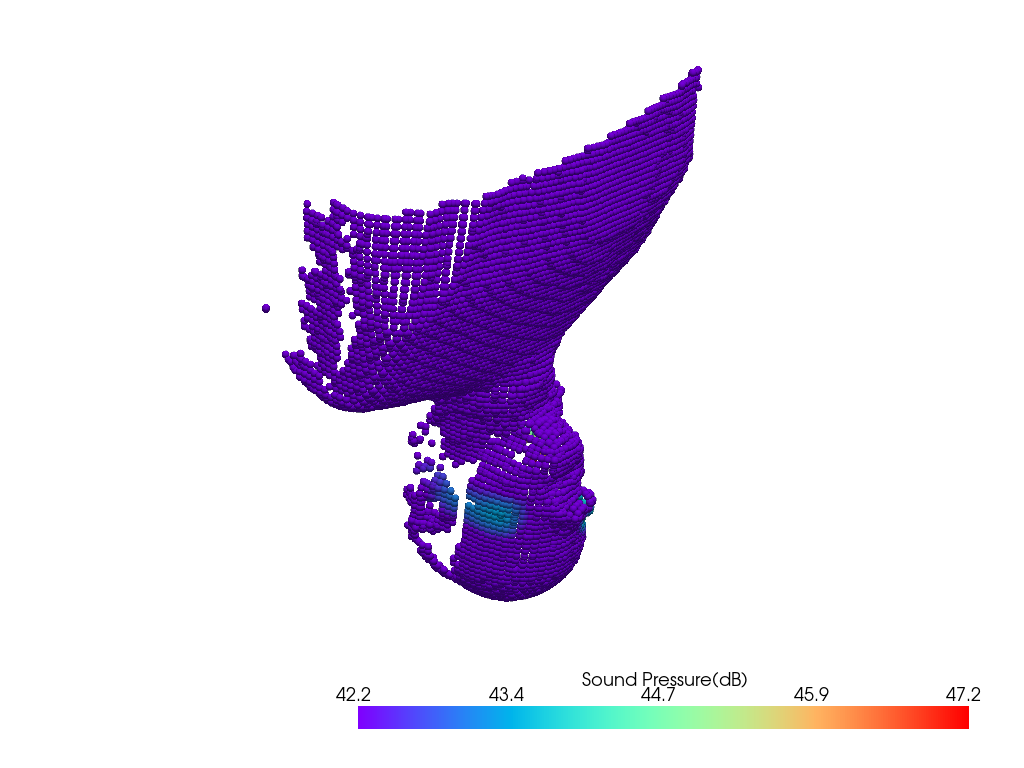

In [4]:

BF_analysis.plot(dynamic_range = 5)


c:\Users\lieng\.conda\envs\my_new_env\envs\environment\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


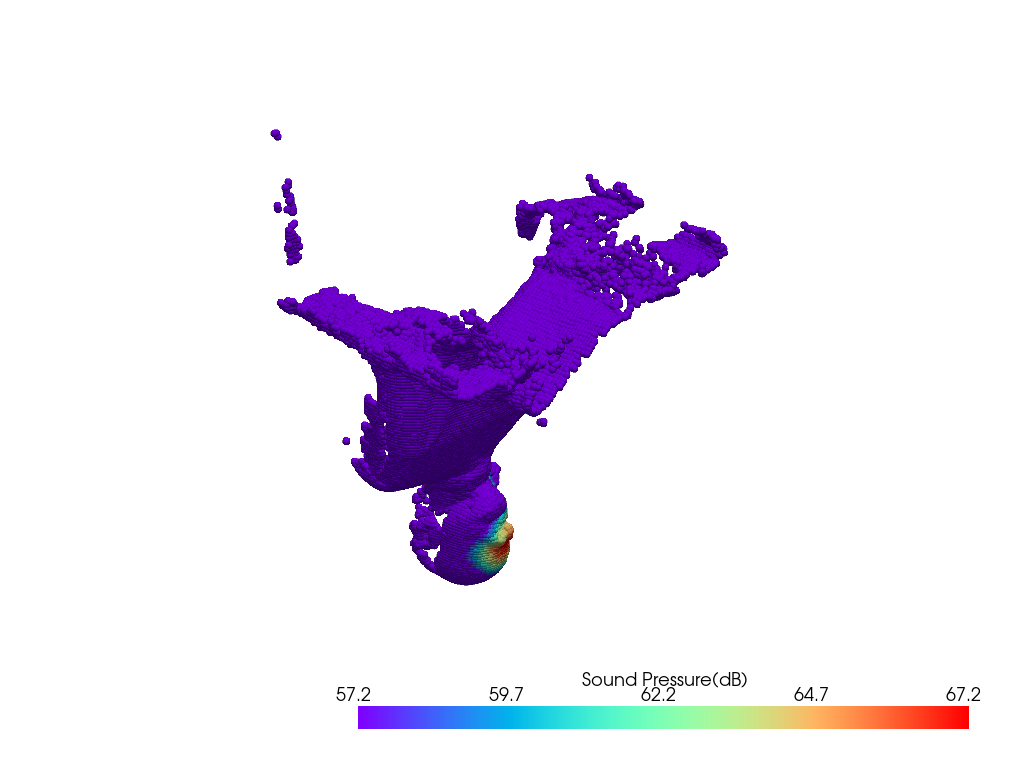

In [9]:
BF_analysis.plot(dynamic_range = 10)